# **This notebook is prepared as the final project for the course BIGDATA-Big Data and Data Mining at EETAC, UPC.**
**In this notebook we made a combined dataset to detect emotion responses from texts using an open source dataset and our own text dataset collected from Twitter (X) in following these steps -**
* Importing necessary Libraries
* Multinomial Naive Bayes
* TF-IDF Vectorizer and logistic regression
* A grid-search for optimal values of TF-IDF
* Bi-LSTM
* Transformers (BERT)
* VIsualization of obtained results
* Testing manually on given sentences

# Importing and Installing libraries

In [ ]:
# General-purpose and data processing libraries
import os
import re
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# TensorFlow / Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Hugging Face Transformers + PyTorch
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification, get_scheduler
)

# Hugging Face Datasets
from datasets import load_dataset

2025-05-28 08:31:28.130703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748421088.348854      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748421088.414448      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Merging our dataset with the open source dataset

**We first import our custom dataset that we collected using X-API, then cleaned and labelled it**

Link to the dataset: https://www.kaggle.com/datasets/hasanccr92/vevfvs

In [ ]:
x_data = pd.read_csv('/kaggle/input/vevfvs/labeled_emotions.csv')

In [ ]:
# custom dataset (x_data) with label mapping
emotion_to_label = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4}
x_data['label'] = x_data['emotion'].map(emotion_to_label)
x_data.head()

,text,created_at,emotion,clean_text,label
0,This is a project that I am exceedingly happy ...,2025-04-10 19:57:53+00:00,joy,This is a project that I am exceedingly happy ...,1
1,@RadioEuropes @Keir_Starmer @MayorofLondon Is ...,2025-04-10 19:57:53+00:00,joy,Is this your safer London? I assume you are ha...,1
2,☘ I was just in it up in this booth off the t...,2025-04-10 19:57:53+00:00,joy,☘ I was just in it up in this booth off the tc...,1
3,Happy to be of service🫡 https://t.co/bZy1IJ1BO...,2025-04-10 19:57:52+00:00,joy,Happy to be of service🫡 https://t.co/bZy1IJ1BO...,1
4,@Eminascrypt Happy Thursday Eminas,2025-04-10 19:57:51+00:00,joy,Happy Thursday Eminas,1


**This is the open-source dataset we will be using for training the model. The dataset is provided by Dair-AI and available on huggingface**

Link to the dataset: https://huggingface.co/datasets/dair-ai/emotion

In [ ]:
ds = load_dataset("dair-ai/emotion", "split")

df_train = pd.DataFrame(ds['train'])
df_val = pd.DataFrame(ds['validation'])
df_test = pd.DataFrame(ds['test'])

print(df_train.head())

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [ ]:
# Remove rows where label == 5 (surprise)
df_train = df_train[df_train['label'] != 5].copy()
df_val = df_val[df_val['label'] != 5].copy()
df_test = df_test[df_test['label'] != 5].copy()

In [ ]:
# Get the emotion class names
emotion_classes = ds['train'].features['label'].names

# Map the numeric labels to their corresponding class names
df_train['emotion'] = df_train['label'].apply(lambda x: emotion_classes[x])
df_val['emotion'] = df_val['label'].apply(lambda x: emotion_classes[x])
df_test['emotion'] = df_test['label'].apply(lambda x: emotion_classes[x])


print(df_train.head())

                                                text  label  emotion
0                            i didnt feel humiliated      0  sadness
1  i can go from feeling so hopeless to so damned...      0  sadness
2   im grabbing a minute to post i feel greedy wrong      3    anger
3  i am ever feeling nostalgic about the fireplac...      2     love
4                               i am feeling grouchy      3    anger


In [ ]:
# Add emotion column to df_train
label_to_emotion = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear'
}
df_train['emotion'] = df_train['label'].map(label_to_emotion)


x_data = x_data[['text', 'label', 'emotion']]  # Select only needed columns

# Merge with df_train
merged_train = pd.concat([df_train, x_data], ignore_index=True)

In [ ]:
merged_train.emotion.unique()

array(['sadness', 'anger', 'love', 'fear', 'joy'], dtype=object)

Very basic processing of texts

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
merged_train['text'] = merged_train['text'].apply(preprocess_text)



# Multinomial Naive Bayes

The simplest model, very quick but the results may not be very accurate

Bag of Words (BoW) represents text as a collection of word counts or frequencies, ignoring word order and grammar, to create numerical features for text analysis.

CountVectorizer then transforms text into a sparse matrix of word counts, capturing the frequency of each word in the vocabulary for feature extraction.

A probabilistic classifier (Multinomial Naive Bayes) uses the word frequencies to predict class probabilities, suitable for discrete data like word counts in text classification.

In [ ]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear'
}

In [ ]:
# Create pipeline with CountVectorizer and MultinomialNB
BowPipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())
])


# Train the model
X = merged_train['text']
y = merged_train['emotion']

start_time = time.time()
BowPipeline.fit(X, y)
train_time_bow = time.time() - start_time
print(f"Training time (Bag of Words): {train_time_bow:.4f} seconds")

Training time (Bag of Words): 0.2434 seconds


**Evaluation**

In [ ]:
# Function to evaluate model
def evaluate_model_bow(X, y_true, dataset_name):
    y_pred = BowPipeline.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, zero_division=0)
    print(f"\nEvaluation on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    return accuracy, report

# Map labels to emotions for validation and test sets
df_val['emotion'] = df_val['label'].map(label_to_emotion)
df_test['emotion'] = df_test['label'].map(label_to_emotion)


In [ ]:
# Evaluate on validation set
X_val = df_val['text']
y_val = df_val['emotion']

start_time_val = time.time()
evaluate_model_bow(X_val, y_val, "Validation Set")
eval_time_val_bow = time.time() - start_time_val
print(f"Evaluation time (Validation Set - BoW): {eval_time_val_bow:.4f} seconds")

# Evaluate on test set
X_test = df_test['text']
y_test = df_test['emotion']

start_time_test = time.time()
evaluate_model_bow(X_test, y_test, "Test Set")
eval_time_test_bow = time.time() - start_time_test
print(f"Evaluation time (Test Set - BoW): {eval_time_test_bow:.4f} seconds")


Evaluation on Validation Set:
Accuracy: 0.8202
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.71      0.80       275
        fear       0.93      0.63      0.75       212
         joy       0.81      0.95      0.88       704
        love       0.94      0.35      0.51       178
     sadness       0.77      0.94      0.84       550

    accuracy                           0.82      1919
   macro avg       0.87      0.71      0.76      1919
weighted avg       0.84      0.82      0.81      1919

Evaluation time (Validation Set - BoW): 0.0577 seconds

Evaluation on Test Set:
Accuracy: 0.8175
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.66      0.77       275
        fear       0.92      0.62      0.74       224
         joy       0.80      0.96      0.87       695
        love       0.87      0.33      0.48       159
     sadness       0.79      0.92      0.85      

In [ ]:
# Function to predict emotion for a new sentence
def predict_emotion_bow(sentence):
    # Preprocess the input sentence
    processed_sentence = preprocess_text(sentence)
    # Predict emotion
    predicted_emotion = BowPipeline.predict([processed_sentence])[0]
    # Get probability scores
    probabilities = BowPipeline.predict_proba([processed_sentence])[0]
    # Get class labels
    classes = pipeline.classes_
    # Create probability dictionary
    prob_dict = {emotion: prob for emotion, prob in zip(classes, probabilities)}
    return predicted_emotion, prob_dict

# TF-IDF and Logistic Regression

Train model using TF-IDF Vectorizer and Logistic Regression
TF-IDF (Term Frequency-Inverse Document Frequency) transforms text into numerical features based on word importance for feature extraction
Logistic Regression used for classification


In [ ]:
# Create pipeline
tfIdfPipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced'))
])

# Train the model
print("\nTraining the model...")
start_time = time.time()
tfIdfPipeline.fit(merged_train['text'], merged_train['label'])
train_time_tfidf = time.time() - start_time

print(f"Training time (TF-IDF + Logistic Regression): {train_time_tfidf:.4f} seconds")


Training the model...
Training time (TF-IDF + Logistic Regression): 3.1797 seconds


In [ ]:
# Evaluate on validation set
print("\nEvaluating on validation set...")
start_time_val = time.time()
val_predictions = tfIdfPipeline.predict(df_val['text'])
eval_time_val_tfidf = time.time() - start_time_val

val_accuracy = accuracy_score(df_val['label'], val_predictions)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Evaluation time (Validation Set - TF-IDF): {eval_time_val_tfidf:.4f} seconds")

# Classification report on validation set
print("\nClassification Report (Validation):")
print(classification_report(df_val['label'], val_predictions, target_names=emotion_map.values()))

# Evaluate on test set
print("\nEvaluating on test set...")
start_time_test = time.time()
test_predictions = tfIdfPipeline.predict(df_test['text'])
eval_time_test_tfidf = time.time() - start_time_test

test_accuracy = accuracy_score(df_test['label'], test_predictions)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Evaluation time (Test Set - TF-IDF): {eval_time_test_tfidf:.4f} seconds")

# Classification report on test set
print("\nClassification Report (Test):")
print(classification_report(df_test['label'], test_predictions, target_names=emotion_map.values()))



Evaluating on validation set...
Validation accuracy: 0.8895
Evaluation time (Validation Set - TF-IDF): 0.0473 seconds

Classification Report (Validation):
              precision    recall  f1-score   support

     sadness       0.86      0.88      0.87       275
         joy       0.84      0.89      0.86       212
        love       0.94      0.88      0.91       704
       anger       0.74      0.95      0.83       178
        fear       0.92      0.89      0.90       550

    accuracy                           0.89      1919
   macro avg       0.86      0.90      0.88      1919
weighted avg       0.90      0.89      0.89      1919


Evaluating on test set...
Test accuracy: 0.8914
Evaluation time (Test Set - TF-IDF): 0.0422 seconds

Classification Report (Test):
              precision    recall  f1-score   support

     sadness       0.86      0.90      0.88       275
         joy       0.88      0.91      0.89       224
        love       0.94      0.88      0.91       695
      

# Grid search for best parameters of TF-IDF

In [ ]:
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1.0, 10.0]
}

print("\nPerforming hyperparameter tuning...")
grid_search = GridSearchCV(tfIdfPipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(merged_train['text'], merged_train['label'])

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the model with best parameters
best_pipeline = grid_search.best_estimator_


Performing hyperparameter tuning...

Best parameters: {'classifier__C': 10.0, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score: 0.8808


In [ ]:
def predict_emotion_log_reg(sentence):
    processed_sentence = preprocess_text(sentence)
    predicted_label = best_pipeline.predict([processed_sentence])[0]
    predicted_emotion = emotion_map[predicted_label]
    probabilities = best_pipeline.predict_proba([processed_sentence])[0]
    prob_dict = {emotion_map[i]: prob for i, prob in enumerate(probabilities)}
    return predicted_emotion, prob_dict

# Bi-LSTM

Bidirectional LSTM processes text in both forward and backward directions, capturing long-range dependencies and context for better emotion understanding.

Embedding Layer converts words into dense vectors, preserving semantic relationships and improving model learning.

Unlike Bag-of-Words, LSTM retains word order, making it better at detecting nuanced emotions in text.


**Preparing Data for LSTM**

In [ ]:
train_df = merged_train
val_df = df_val
test_df = df_test

# Prepare texts and labels
X_train = train_df['text'].values
y_train = train_df['label'].values

X_val = val_df['text'].values
y_val = val_df['label'].values

X_test = test_df['text'].values
y_test = test_df['label'].values

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

**Tokenizing text and padding**

In [ ]:
# Tokenize for LSTM
lstm_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(X_train)
vocab_size = len(lstm_tokenizer.word_index) + 1

# Pad sequences for LSTM
max_len = 100
X_train_seq = pad_sequences(lstm_tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
X_val_seq = pad_sequences(lstm_tokenizer.texts_to_sequences(X_val), maxlen=max_len, padding='post')
X_test_seq = pad_sequences(lstm_tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

**Building Model**

In [ ]:
# Build BiLSTM model
LSTMmodel = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

LSTMmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#LSTMmodel.summary()

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748421117.225170      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**Train**

**Embedding Layer:** Converts word indices to dense 128D vectors.

**Bidirectional LSTM** (64 units): Processes input both forward and backward, outputting a 128D vector (64×2). Captures full context of the sequence.

**Dropout (0.5):** Prevents overfitting by randomly deactivating 50% of neurons.

**ReLU activation:** Learns non-linear combinations of BiLSTM features.

**Early Stopping** is used if validation loss doesn’t improve for 3 epochs.

**Device:** Tesla P100-PCIE-16GB

In [ ]:
start_time = time.time()

LSTMmodel.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

train_time_lstm = time.time() - start_time
print(f"Training time (LSTM): {train_time_lstm:.4f} seconds")

Epoch 1/10
494/494 - 6s - 13ms/step - accuracy: 0.9577 - loss: 0.1415 - val_accuracy: 0.9062 - val_loss: 0.4209
Epoch 2/10
494/494 - 6s - 13ms/step - accuracy: 0.9642 - loss: 0.1207 - val_accuracy: 0.9171 - val_loss: 0.3238
Epoch 3/10
494/494 - 6s - 13ms/step - accuracy: 0.9729 - loss: 0.0909 - val_accuracy: 0.9114 - val_loss: 0.3514
Training time (LSTM): 19.0290 seconds


**Evaluate**

In [ ]:
# Evaluate on validation set
start_time_val = time.time()
val_loss, val_acc = LSTMmodel.evaluate(X_val_seq, y_val_cat, verbose=0)
eval_time_val_lstm = time.time() - start_time_val
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Evaluation time (Validation Set - LSTM): {eval_time_val_lstm:.4f} seconds")

# Evaluate on test set
start_time_test = time.time()
test_loss, test_acc = LSTMmodel.evaluate(X_test_seq, y_test_cat, verbose=0)
eval_time_test_lstm = time.time() - start_time_test
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Evaluation time (Test Set - LSTM): {eval_time_test_lstm:.4f} seconds")

Validation Accuracy: 0.9062
Evaluation time (Validation Set - LSTM): 0.3963 seconds
Test Accuracy: 0.9090
Evaluation time (Test Set - LSTM): 0.3706 seconds


In [ ]:
# Classification report for validation set
y_val_pred = LSTMmodel.predict(X_val_seq, verbose=0)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_cat, axis=1)

print(f"Validation accuracy: {val_acc:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val_true_classes, y_val_pred_classes,
                          target_names=list(emotion_map.values())))

# Classification report for test set
y_test_pred = LSTMmodel.predict(X_test_seq, verbose=0)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_cat, axis=1)

print(f"Test accuracy: {test_acc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test_true_classes, y_test_pred_classes,
                          target_names=list(emotion_map.values())))

Validation accuracy: 0.9062

Classification Report (Validation):
              precision    recall  f1-score   support

     sadness       0.94      0.93      0.93       550
         joy       0.89      0.96      0.92       704
        love       0.87      0.74      0.80       178
       anger       0.95      0.87      0.90       275
        fear       0.87      0.86      0.86       212

    accuracy                           0.91      1919
   macro avg       0.90      0.87      0.88      1919
weighted avg       0.91      0.91      0.91      1919

Test accuracy: 0.9090

Classification Report (Test):
              precision    recall  f1-score   support

     sadness       0.97      0.92      0.94       581
         joy       0.86      0.97      0.91       695
        love       0.83      0.69      0.75       159
       anger       0.96      0.87      0.91       275
        fear       0.92      0.92      0.92       224

    accuracy                           0.91      1934
   macro avg 

**Function to use later**

In [ ]:
def predict_emotion_bilstm(sentence):
    sequence = lstm_tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    pred = LSTMmodel.predict(padded)[0]
    predicted_emotion = label_encoder.inverse_transform([np.argmax(pred)])[0]
    prob_dict = {emotion: float(prob) for emotion, prob in zip(label_encoder.classes_, pred)}
    return predicted_emotion, prob_dict

# Transformers (BERT)

BERT is pre-trained on a massive amount of text (Wikipedia, books), so it already understands grammar, word relationships, and general language structure
BERT reads sentences bidirectionally, meaning it looks at the full context (both before and after each word

**Preparing data for BERT**

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
merged_train['label'] = label_encoder.fit_transform(merged_train['emotion'])
df_val['label'] = label_encoder.transform(df_val['emotion'])
df_test['label'] = label_encoder.transform(df_test['emotion'])

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create a custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = EmotionDataset(merged_train)
val_dataset = EmotionDataset(df_val)
test_dataset = EmotionDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Defining parameters and choosing GPU for parallel processing

**Used in Training**

Model: BERT base model (uncased)

Parameters: 110M

Device: Tesla P100-PCIE-16GB

Framework: PyTorch

Epoch: 5

Optimizer: Adam


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BertModel = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))
BertModel.to(device)

optimizer = AdamW(BertModel.parameters(), lr=2e-5)
num_epochs = 5
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
start_time = time.time()

BertModel.train()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    progress_bar = tqdm(train_loader)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = BertModel(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.set_description(f"Loss: {loss.item():.4f}")

train_time_bert = time.time() - start_time
print(f"Training time (BERT): {train_time_bert:.4f} seconds")

Epoch 1/5


Loss: 0.0539: 100%|██████████| 987/987 [03:27<00:00,  4.75it/s]


Epoch 2/5


Loss: 0.0361: 100%|██████████| 987/987 [03:26<00:00,  4.78it/s]


Epoch 3/5


Loss: 0.0024: 100%|██████████| 987/987 [03:26<00:00,  4.78it/s]


Epoch 4/5


Loss: 0.0516: 100%|██████████| 987/987 [03:26<00:00,  4.78it/s]


Epoch 5/5


Loss: 0.0859: 100%|██████████| 987/987 [03:26<00:00,  4.78it/s]

Training time (BERT): 1033.8034 seconds


In [ ]:
def evaluate(loader):
   BertModel.eval()
   preds, labels = [], []
   with torch.no_grad():
       for batch in loader:
           batch = {k: v.to(device) for k, v in batch.items()}
           outputs = BertModel(**batch)
           logits = outputs.logits
           preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
           labels.extend(batch['labels'].cpu().numpy())

   accuracy = accuracy_score(labels, preds)
   clf_report = classification_report(labels, preds, target_names=label_encoder.classes_)
   return accuracy, clf_report

# Evaluate on validation set
start_time_val = time.time()
val_acc, val_report = evaluate(val_loader)
eval_time_val_bert = time.time() - start_time_val
print(f"Validation accuracy: {val_acc:.4f}")
print("Validation Report:\n", val_report)
print(f"Evaluation time (Validation Set - BERT): {eval_time_val_bert:.4f} seconds")

# Evaluate on test set
start_time_test = time.time()
test_acc, test_report = evaluate(test_loader)
eval_time_test_bert = time.time() - start_time_test
print(f"Test accuracy: {test_acc:.4f}")
print("Test Report:\n", test_report)
print(f"Evaluation time (Test Set - BERT): {eval_time_test_bert:.4f} seconds")

Validation accuracy: 0.9458
Validation Report:
               precision    recall  f1-score   support

       anger       0.95      0.94      0.94       275
        fear       0.95      0.90      0.92       212
         joy       0.96      0.96      0.96       704
        love       0.87      0.87      0.87       178
     sadness       0.95      0.98      0.97       550

    accuracy                           0.95      1919
   macro avg       0.93      0.93      0.93      1919
weighted avg       0.95      0.95      0.95      1919

Evaluation time (Validation Set - BERT): 7.2995 seconds
Test accuracy: 0.9416
Test Report:
               precision    recall  f1-score   support

       anger       0.92      0.92      0.92       275
        fear       0.95      0.93      0.94       224
         joy       0.95      0.95      0.95       695
        love       0.84      0.83      0.83       159
     sadness       0.97      0.97      0.97       581

    accuracy                           0.94  

In [ ]:
def predict_emotion_bert(text):
    BertModel.eval()
    with torch.no_grad():
        encoding = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        output = BertModel(input_ids=input_ids, attention_mask=attention_mask)
        logits = output.logits
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

        predicted_idx = probs.argmax()
        predicted_emotion = label_encoder.inverse_transform([predicted_idx])[0]

        # Convert to {emotion: probability} dictionary
        emotion_probs = {
            label_encoder.inverse_transform([i])[0]: float(probs[i])
            for i in range(len(probs))
        }

        return predicted_emotion, emotion_probs

# Visualization of Results

**Training, Testing and Validation Time across models**

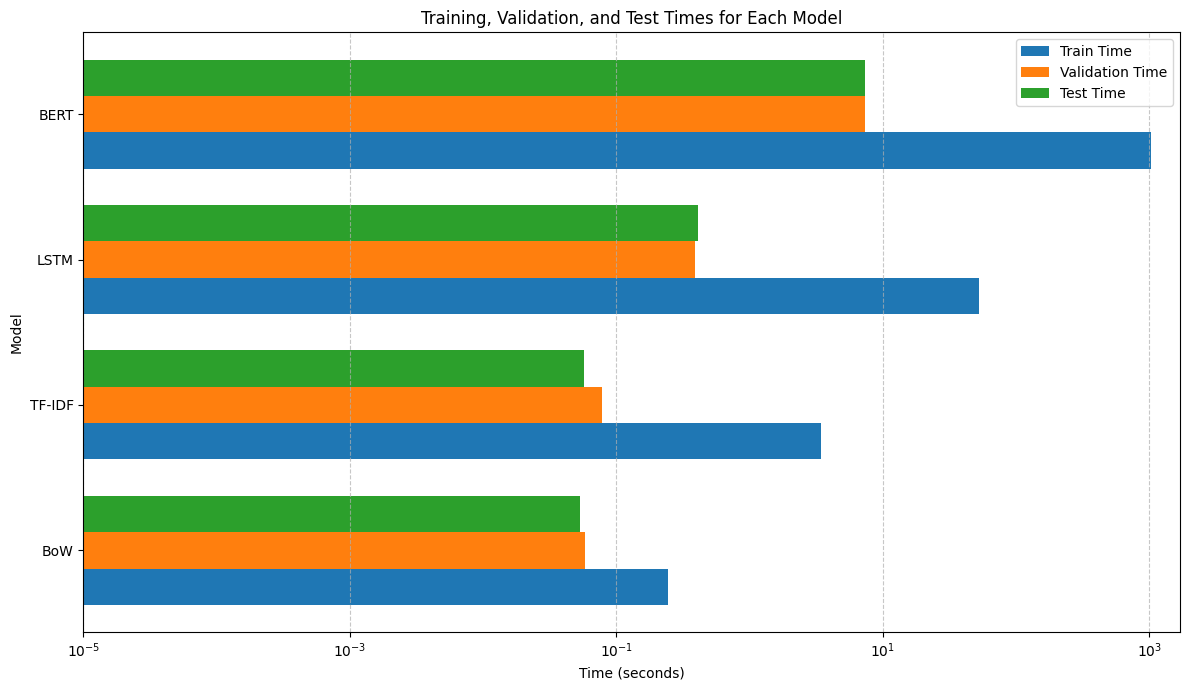

In [ ]:
# Time values
train_times = [train_time_bow, train_time_tfidf, train_time_lstm, train_time_bert]
val_times = [eval_time_val_bow, eval_time_val_tfidf, eval_time_val_lstm, eval_time_val_bert]
test_times = [eval_time_test_bow, eval_time_test_tfidf, eval_time_test_lstm, eval_time_test_bert]

# Model labels
models = ['BoW', 'TF-IDF', 'LSTM', 'BERT']
y = np.arange(len(models))  # label locations
height = 0.25

plt.figure(figsize=(12, 7))

plt.barh(y - height, train_times, height, label='Train Time')
plt.barh(y, val_times, height, label='Validation Time')
plt.barh(y + height, test_times, height, label='Test Time')

plt.xscale('log') #log scaling because some values are very very small
plt.xlim(left=1e-5)

plt.ylabel('Model')
plt.xlabel('Time (seconds)')
plt.title('Training, Validation, and Test Times for Each Model')
plt.yticks(y, models)

plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Accuracy (Train, Validation and Test)**

In [ ]:
# BoW accuracies
train_accuracy_bow = accuracy_score(merged_train['emotion'], BowPipeline.predict(merged_train['text']))
val_accuracy_bow = accuracy_score(df_val['emotion'], BowPipeline.predict(df_val['text']))
test_accuracy_bow = accuracy_score(df_test['emotion'], BowPipeline.predict(df_test['text']))

# TF-IDF accuracies
train_accuracy_tfidf = accuracy_score(merged_train['label'], tfIdfPipeline.predict(merged_train['text']))
val_accuracy_tfidf = accuracy_score(df_val['label'], tfIdfPipeline.predict(df_val['text']))
test_accuracy_tfidf = accuracy_score(df_test['label'], tfIdfPipeline.predict(df_test['text']))

# LSTM accuracies
_, train_accuracy_lstm = LSTMmodel.evaluate(X_train_seq, y_train_cat, verbose=0)
_, val_accuracy_lstm = LSTMmodel.evaluate(X_val_seq, y_val_cat, verbose=0)
_, test_accuracy_lstm = LSTMmodel.evaluate(X_test_seq, y_test_cat, verbose=0)

def get_accuracy(loader):
    BertModel.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = BertModel(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())
    acc = accuracy_score(labels, preds)
    return acc, labels, preds

train_accuracy_bert, y_train_bert, y_pred_train_bert = get_accuracy(train_loader)
val_accuracy_bert, y_val_bert, y_pred_val_bert = get_accuracy(val_loader)
test_accuracy_bert, y_test_bert, y_pred_bert = get_accuracy(test_loader)

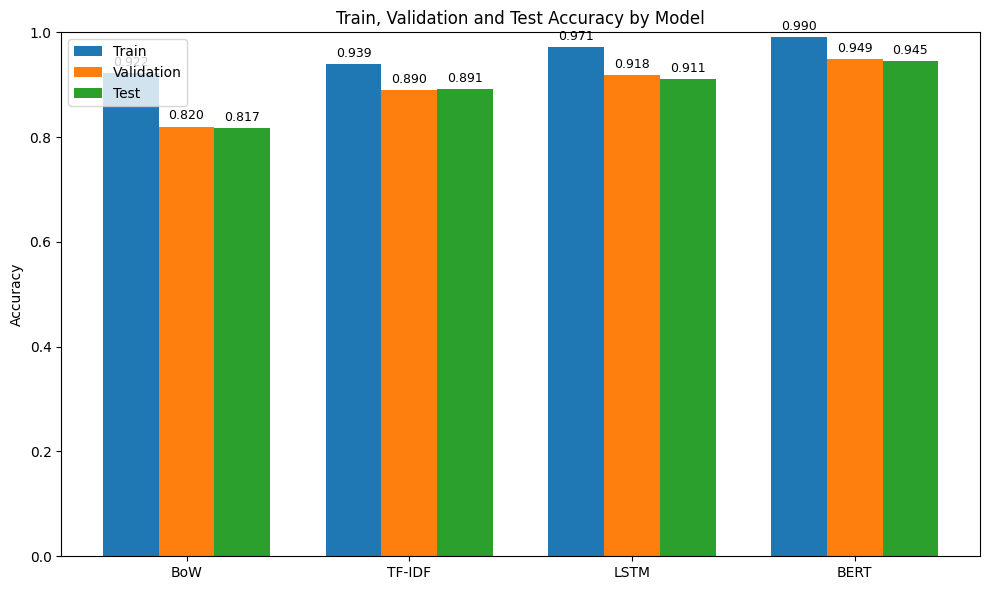

In [ ]:
# Accuracy values
train_acc = [train_accuracy_bow, train_accuracy_tfidf, train_accuracy_lstm, train_accuracy_bert]
val_acc = [val_accuracy_bow, val_accuracy_tfidf, val_accuracy_lstm, val_accuracy_bert]
test_acc = [test_accuracy_bow, test_accuracy_tfidf, test_accuracy_lstm, test_accuracy_bert]

models = ['BoW', 'TF-IDF', 'LSTM', 'BERT']
x = np.arange(len(models))  # label locations
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, train_acc, width, label='Train')
bars2 = ax.bar(x, val_acc, width, label='Validation')
bars3 = ax.bar(x + width, test_acc, width, label='Test')

# Labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Train, Validation and Test Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)  # Accuracy between 0 and 1
ax.legend()

def attach_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

attach_labels(bars1)
attach_labels(bars2)
attach_labels(bars3)

plt.tight_layout()
plt.show()


**Confusion Matrix on Test**

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


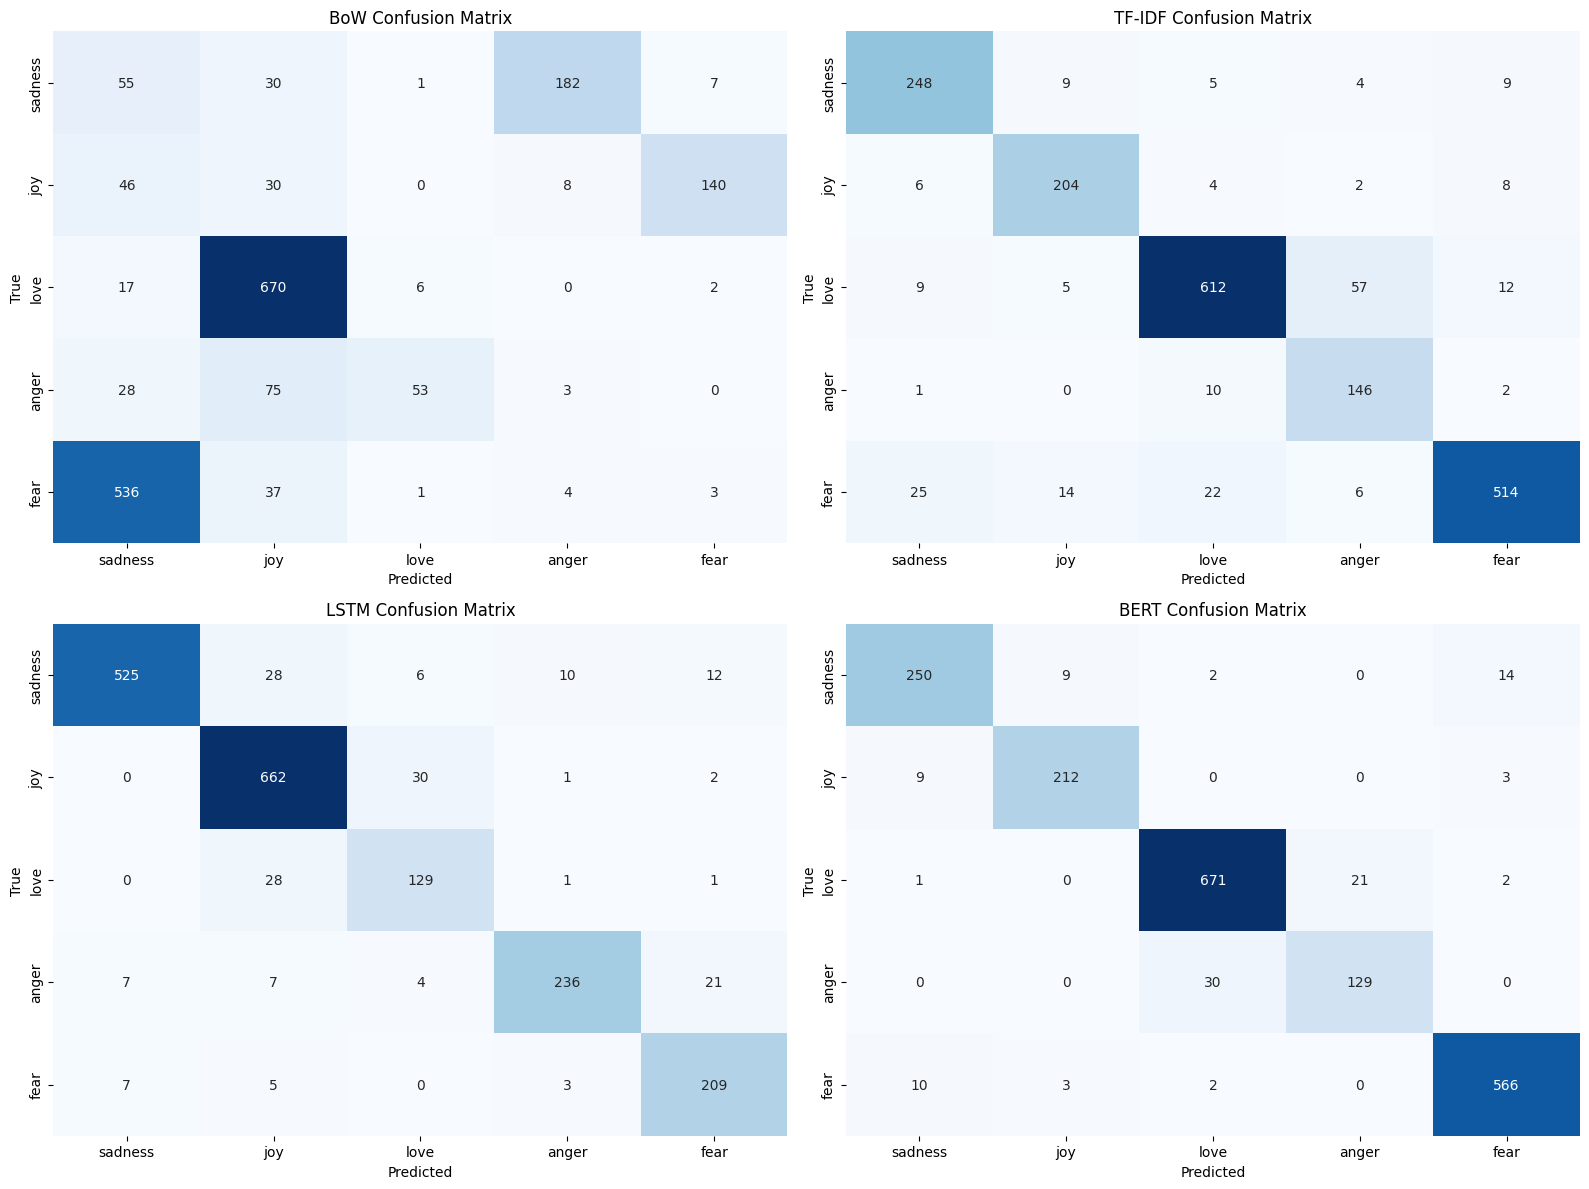

In [ ]:
emotion_to_label = {v: k for k, v in emotion_map.items()}
y_pred_probs = LSTMmodel.predict(X_test_seq)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
y_test_lstm = np.argmax(y_test_cat, axis=1)

# If any predictions are emotion strings, map them to labels
def map_emotions_to_labels(array_like):
    return [emotion_to_label[x] if isinstance(x, str) else x for x in array_like]
def plot_conf_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=list(emotion_map.keys()))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels,
                ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_conf_matrix(
    map_emotions_to_labels(df_test['label']),
    map_emotions_to_labels(BowPipeline.predict(df_test['text'])),
    "BoW Confusion Matrix", axes[0, 0]
)

plot_conf_matrix(
    map_emotions_to_labels(df_test['label']),
    map_emotions_to_labels(tfIdfPipeline.predict(df_test['text'])),
    "TF-IDF Confusion Matrix", axes[0, 1]
)

plot_conf_matrix(
    map_emotions_to_labels(y_test_lstm),
    map_emotions_to_labels(y_pred_lstm),
    "LSTM Confusion Matrix", axes[1, 0]
)

plot_conf_matrix(
    map_emotions_to_labels(y_test_bert),
    map_emotions_to_labels(y_pred_bert),
    "BERT Confusion Matrix", axes[1, 1]
)

plt.tight_layout()
plt.show()



**Precision, Recall, F1**

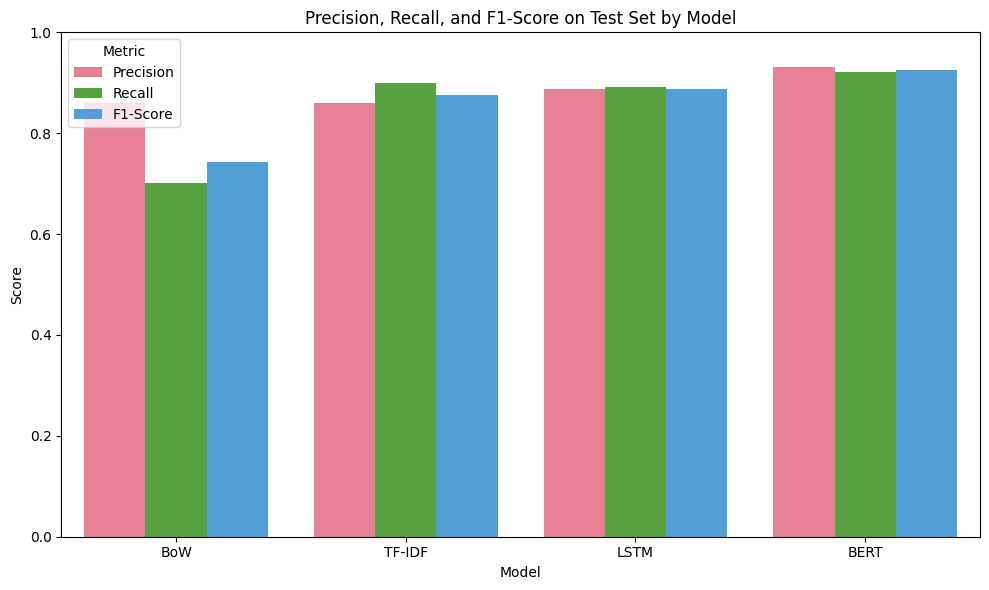

In [ ]:
def extract_macro_scores(report):
    return {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1-score": report["macro avg"]["f1-score"]
    }

# For BoW
report_bow = classification_report(df_test['emotion'], BowPipeline.predict(df_test['text']), output_dict=True, zero_division=0)
scores_bow = extract_macro_scores(report_bow)

# For TF-IDF
report_tfidf = classification_report(df_test['label'], tfIdfPipeline.predict(df_test['text']), output_dict=True, zero_division=0)
scores_tfidf = extract_macro_scores(report_tfidf)

# For LSTM
report_lstm = classification_report(y_test_lstm, y_pred_lstm, output_dict=True, zero_division=0)
scores_lstm = extract_macro_scores(report_lstm)

# For BERT
report_bert = classification_report(y_test_bert, y_pred_bert, output_dict=True, zero_division=0)
scores_bert = extract_macro_scores(report_bert)

# Prepare the data
metrics_data = {
    "Model": ["BoW"] * 3 + ["TF-IDF"] * 3 + ["LSTM"] * 3 + ["BERT"] * 3,
    "Metric": ["Precision", "Recall", "F1-Score"] * 4,
    "Score": [
        scores_bow["precision"], scores_bow["recall"], scores_bow["f1-score"],
        scores_tfidf["precision"], scores_tfidf["recall"], scores_tfidf["f1-score"],
        scores_lstm["precision"], scores_lstm["recall"], scores_lstm["f1-score"],
        scores_bert["precision"], scores_bert["recall"], scores_bert["f1-score"],
    ]
}

df_metrics = pd.DataFrame(metrics_data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x="Model", y="Score", hue="Metric", palette="husl")
plt.ylim(0, 1)
plt.title("Precision, Recall, and F1-Score on Test Set by Model")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

BERT has the highest accuracy from all models (94.16%)  in emotion classification, followed by LSTM at 91.05%. BERT and LSTM excel in capturing contextual nuances but demand significant computational resources. Models like BERT and LSTM effectively handle complex sentiment cues by preserving word order and context while other traditional model like Naive Bayes overlooks these sequential relationships.

Naive Bayes and TF-IDF are faster and less resource-intensive.

The selection of the model depends on the computational resources that are available and the level of accuracy required


# Test manually on custom sentences

**Choosing any of the models**

In [ ]:
def choose_emotion_model():
    print("Choose a model to predict emotion:")
    print("1 - Bag of Words (BoW)")
    print("2 - Logistic Regression")
    print("3 - BiLSTM")
    print("4 - BERT")

    choice = input("Enter your choice (1-4): ").strip()

    model_map = {
        '1': predict_emotion_bow,
        '2': predict_emotion_log_reg,
        '3': predict_emotion_bilstm,
        '4': predict_emotion_bert
    }

    if choice not in model_map:
        print("Invalid choice. Please select a number between 1 and 4.")
        return None

    return model_map[choice]
model_function = choose_emotion_model()

Choose a model to predict emotion:
1 - Bag of Words (BoW)
2 - Logistic Regression
3 - BiLSTM
4 - BERT


Enter your choice (1-4):  4


**The sentence to be put in new_sentence variable**

In [ ]:
def run_emotion_prediction(model_func):
    if model_func is None:
        print("No model selected.")
        return

    new_sentence = "I love bigdata"
    emotion, probs = model_func(new_sentence)

    print(f"\nPrediction:")
    print(f"Sentence: {new_sentence}")
    print(f"Predicted Emotion: {emotion}")
    print("Probabilities:")
    for emo, prob in probs.items():
        print(f"{emo}: {prob:.4f}")
run_emotion_prediction(model_function)


Prediction:
Sentence: I love bigdata
Predicted Emotion: love
Probabilities:
anger: 0.0010
fear: 0.0003
joy: 0.0660
love: 0.9305
sadness: 0.0023
